In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# minimal version of the Google colab notebook, useful for running locally

In [40]:
import logging
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

logging.basicConfig(level=logging.INFO)

In [4]:
from galaxy_datasets import demo_rings

data_dir = 'tmp'

train_catalog, _ = demo_rings(root=data_dir, download=True, train=True)
test_catalog, _ = demo_rings(root=data_dir, download=True, train=False)

INFO:root:Setting up demo_rings dataset
INFO:root:Checking integrity of resources
INFO:root:Resource status: <zip object at 0x741584140ac0>
INFO:root:All resources ready: True
INFO:root:Images unpacked: False (tmp/images, ['images/313982/313982_3559.jpg', 'images/374032/374032_255.jpg'])
INFO:root:Downloading https://dl.dropboxusercontent.com/s/4cfb9xbnlkvbkv1/demo_rings_train_catalog.parquet
INFO:root:Downloading non-archive file - demo_rings_train_catalog.parquet
INFO:root:Downloading https://dl.dropboxusercontent.com/s/xghqujm41ujjlko/demo_rings_test_catalog.parquet
INFO:root:Downloading non-archive file - demo_rings_test_catalog.parquet
INFO:root:Downloading https://dl.dropboxusercontent.com/s/80s5j6dygtw0gu6/demo_rings_images.tar.gz


Using downloaded and verified file: tmp/demo_rings_train_catalog.parquet
Using downloaded and verified file: tmp/demo_rings_test_catalog.parquet
Using downloaded and verified file: tmp/demo_rings_images.tar.gz
Extracting tmp/demo_rings_images.tar.gz to tmp


INFO:root:demo_rings dataset ready
INFO:root:Setting up demo_rings dataset
INFO:root:Checking integrity of resources
INFO:root:Resource status: <zip object at 0x74157fb45780>
INFO:root:All resources ready: True
INFO:root:Images unpacked: False (tmp/images, ['images/313982/313982_3559.jpg', 'images/374032/374032_255.jpg'])
INFO:root:Downloading https://dl.dropboxusercontent.com/s/4cfb9xbnlkvbkv1/demo_rings_train_catalog.parquet
INFO:root:Downloading non-archive file - demo_rings_train_catalog.parquet
INFO:root:Downloading https://dl.dropboxusercontent.com/s/xghqujm41ujjlko/demo_rings_test_catalog.parquet
INFO:root:Downloading non-archive file - demo_rings_test_catalog.parquet
INFO:root:Downloading https://dl.dropboxusercontent.com/s/80s5j6dygtw0gu6/demo_rings_images.tar.gz


Using downloaded and verified file: tmp/demo_rings_train_catalog.parquet
Using downloaded and verified file: tmp/demo_rings_test_catalog.parquet
Using downloaded and verified file: tmp/demo_rings_images.tar.gz
Extracting tmp/demo_rings_images.tar.gz to tmp


INFO:root:demo_rings dataset ready


In [5]:
assert all([os.path.isfile(loc) for loc in train_catalog['file_loc']])

In [6]:
train_catalog['ring'] = train_catalog['ring'].astype(int)
test_catalog['ring'] = test_catalog['ring'].astype(int)

In [7]:
label_cols = ['ring']  # will use later

In [8]:
from galaxy_datasets.pytorch.galaxy_datamodule import CatalogDataModule
from galaxy_datasets.transforms import default_view_config, get_galaxy_transform

# this two-liner uses the galaxy_datasets repo to create a torchvision transformation designed for galaxies
transform_cfg = default_view_config()  # customise here
transform = get_galaxy_transform(transform_cfg)

# for loading a dataframe with labels and image paths
# see also HuggingFaceDataModule for HF datasets
datamodule = CatalogDataModule(
    label_cols=label_cols,  # specifying which columns to load as labels with `label_cols`
    catalog=train_catalog ,
    train_transform=transform,
    test_transform=transform,
    batch_size=32,  # small batch size because our gpu has limited memory
    num_workers=2,  # sets the parallelism for loading data. 2 works well on colab.
    # num_workers=0
  )


INFO:datasets:PyTorch version 2.7.0 available.
INFO:root:Using view transform config: {'pil_to_tensor': True, 'flux_to_jpg_like_dynamic_range': False, 'fixed_crop': False, 'output_size': 224, 'greyscale': False, 'interpolation_method': 'bilinear', 'random_affine': {'degrees': 90, 'translate': [0.1, 0.1], 'scale': [1.2, 1.4], 'shear': [0, 20, 0, 20]}, 'random_perspective': False, 'center_crop': False, 'random_resized_crop': False, 'flip_prob': 0.5, 'rotation_prob': 0.0, 'color_jitter_prob': 0.0, 'erase_iterations': 5, 'random_erasing': {'p': 1.0, 'scale': [0.002, 0.007], 'ratio': [0.5, 2.0]}, 'posterize': False, 'elastic_prob': 0.0, 'normalize': False}
INFO:root:Using RandomAffine with safety crop, {'degrees': 90, 'translate': [0.1, 0.1], 'scale': [1.2, 1.4], 'shear': [0, 20, 0, 20]}
INFO:root:Num workers: 2
INFO:root:Prefetch factor: 4


In [9]:
from zoobot.pytorch.training.finetune import FinetuneableZoobotClassifier

model = FinetuneableZoobotClassifier(
    # arguments for any FinetuneableZoobot class
    # there are many options for customizing finetuning. See the FinetuneableZoobotAbstract docstring.
    name='hf_hub:mwalmsley/zoobot-encoder-convnext_nano',
    training_mode="full",  # Finetune this many blocks. Set 0 for only the head. Set e.g. 1, 2 to finetune deeper (5 max for convnext).
    learning_rate=1e-5,  # use a low learning rate
    layer_decay=0.8,  # reduce the learning rate from lr to lr^0.8 for each block deeper in the network
    # arguments specific to FinetuneableZoobotClassifier
    num_classes=2,
    label_col='ring'
    # greyscale=True, # optionally, convert the pretrained model for greyscale (single channel) images. Equiv. to timm_kwargs={'in_chans': 1}.
)


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (mwalmsley/zoobot-encoder-convnext_nano)
INFO:root:Using classification head and cross-entropy loss
INFO:root:num_classes: 2
INFO:root:Using binary classification


In [10]:
from zoobot.pytorch.training.finetune import get_trainer

# TODO you can update these paths to suit own data
save_dir = os.path.join('examples/finetuning/tmp/finetune_colab')

trainer = get_trainer(save_dir, accelerator="auto", devices=1, strategy="auto", max_epochs=30) # works on tpu ;)
trainer.fit(model, datamodule)
# should reach about 85% accuracy, loss of about 0.40, in a few minutes


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/walml/miniforge3/envs/zoobot39_dev/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/walml/miniforge3/envs/zoobot39_dev/lib/python3.9/site-packages

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/walml/miniforge3/envs/zoobot39_dev/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 17: 'finetuning/val_loss' reached 0.58558 (best 0.58558), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/0.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 17: 'finetuning/val_loss' reached 0.58558 (best 0.58558), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/0.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 34: 'finetuning/val_loss' reached 0.54339 (best 0.54339), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/1.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 34: 'finetuning/val_loss' reached 0.54339 (best 0.54339), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 51: 'finetuning/val_loss' reached 0.52413 (best 0.52413), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/2.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 51: 'finetuning/val_loss' reached 0.52413 (best 0.52413), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 68: 'finetuning/val_loss' reached 0.49356 (best 0.49356), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/3.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 68: 'finetuning/val_loss' reached 0.49356 (best 0.49356), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 85: 'finetuning/val_loss' reached 0.46277 (best 0.46277), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/4.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 85: 'finetuning/val_loss' reached 0.46277 (best 0.46277), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 102: 'finetuning/val_loss' reached 0.45502 (best 0.45502), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/5.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 102: 'finetuning/val_loss' reached 0.45502 (best 0.45502), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 119: 'finetuning/val_loss' reached 0.41025 (best 0.41025), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/6.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 119: 'finetuning/val_loss' reached 0.41025 (best 0.41025), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/6.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 136: 'finetuning/val_loss' reached 0.36559 (best 0.36559), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/7.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 136: 'finetuning/val_loss' reached 0.36559 (best 0.36559), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/7.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 153: 'finetuning/val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 153: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 170: 'finetuning/val_loss' reached 0.33998 (best 0.33998), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/9.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 170: 'finetuning/val_loss' reached 0.33998 (best 0.33998), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/9.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 187: 'finetuning/val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 187: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 204: 'finetuning/val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 204: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 12, global step 221: 'finetuning/val_loss' reached 0.30476 (best 0.30476), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/12.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 221: 'finetuning/val_loss' reached 0.30476 (best 0.30476), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/12.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 13, global step 238: 'finetuning/val_loss' reached 0.29311 (best 0.29311), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/13.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 238: 'finetuning/val_loss' reached 0.29311 (best 0.29311), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/13.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 14, global step 255: 'finetuning/val_loss' reached 0.28508 (best 0.28508), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/14.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 255: 'finetuning/val_loss' reached 0.28508 (best 0.28508), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/14.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 15, global step 272: 'finetuning/val_loss' reached 0.28472 (best 0.28472), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/15.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 15, global step 272: 'finetuning/val_loss' reached 0.28472 (best 0.28472), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/15.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 16, global step 289: 'finetuning/val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 16, global step 289: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 17, global step 306: 'finetuning/val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 306: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 18, global step 323: 'finetuning/val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 18, global step 323: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 19, global step 340: 'finetuning/val_loss' reached 0.27694 (best 0.27694), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/19.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 19, global step 340: 'finetuning/val_loss' reached 0.27694 (best 0.27694), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/19.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 20, global step 357: 'finetuning/val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 20, global step 357: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 21, global step 374: 'finetuning/val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 21, global step 374: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 22, global step 391: 'finetuning/val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 22, global step 391: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 23, global step 408: 'finetuning/val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 23, global step 408: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 24, global step 425: 'finetuning/val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 24, global step 425: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 25, global step 442: 'finetuning/val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 25, global step 442: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 26, global step 459: 'finetuning/val_loss' reached 0.27378 (best 0.27378), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/26.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 26, global step 459: 'finetuning/val_loss' reached 0.27378 (best 0.27378), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/26.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 27, global step 476: 'finetuning/val_loss' reached 0.24438 (best 0.24438), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/27.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 27, global step 476: 'finetuning/val_loss' reached 0.24438 (best 0.24438), saving model to '/home/walml/repos/zoobot/examples/finetuning/examples/finetuning/tmp/finetune_colab/checkpoints/27.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 28, global step 493: 'finetuning/val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 28, global step 493: 'finetuning/val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 29, global step 510: 'finetuning/val_loss' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 29, global step 510: 'finetuning/val_loss' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [11]:
best_checkpoint = trainer.checkpoint_callback.best_model_path
finetuned_model = FinetuneableZoobotClassifier.load_from_checkpoint(best_checkpoint)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (mwalmsley/zoobot-encoder-convnext_nano)
INFO:root:Using classification head and cross-entropy loss
INFO:root:num_classes: 2
INFO:root:Using binary classification


In [32]:
from zoobot.pytorch.predictions import predict_on_catalog

predictions = predict_on_catalog.predict(
  test_catalog,
  finetuned_model,
  inference_transform=transform,
  label_cols=['not_ring_pred', 'ring_pred'],  # name the output columns
  # save_loc=os.path.join(save_dir, 'finetuned_predictions.csv'),
  trainer_kwargs={'accelerator': 'gpu'},
  datamodule_kwargs={'num_workers': 2, 'batch_size': 32},
)
predictions.head()

INFO:root:Using view transform config: {'pil_to_tensor': True, 'flux_to_jpg_like_dynamic_range': False, 'fixed_crop': False, 'output_size': 224, 'greyscale': False, 'interpolation_method': 'bilinear', 'random_affine': {'degrees': 90, 'translate': [0.1, 0.1], 'scale': [1.2, 1.4], 'shear': [0, 20, 0, 20]}, 'random_perspective': False, 'center_crop': False, 'random_resized_crop': False, 'flip_prob': 0.5, 'rotation_prob': 0.0, 'color_jitter_prob': 0.0, 'erase_iterations': 5, 'random_erasing': {'p': 1.0, 'scale': [0.002, 0.007], 'ratio': [0.5, 2.0]}, 'posterize': False, 'elastic_prob': 0.0, 'normalize': False}
INFO:root:Using RandomAffine with safety crop, {'degrees': 90, 'translate': [0.1, 0.1], 'scale': [1.2, 1.4], 'shear': [0, 20, 0, 20]}
INFO:root:Num workers: 2
INFO:root:Prefetch factor: 4
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning mode

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:root:Predictions complete - torch.Size([200, 2])


,not_ring_pred,ring_pred,id_str
0,0.021307,0.978693,453526_3245
1,0.046065,0.953935,127202_5277
2,0.947870,0.052130,469597_327
3,0.954798,0.045202,433105_1762
4,0.018579,0.981421,52497_3109


In [ ]:
predictions = pd.merge(predictions, test_catalog[['id_str', 'file_loc', 'ring']], how='inner', on='id_str')
predictions.head()

,not_ring_pred,ring_pred,id_str,file_loc,ring
0,0.021307,0.978693,453526_3245,tmp/images/453526/453526_3245.jpg,1
1,0.046065,0.953935,127202_5277,tmp/images/127202/127202_5277.jpg,1
2,0.947870,0.052130,469597_327,tmp/images/469597/469597_327.jpg,0
3,0.954798,0.045202,433105_1762,tmp/images/433105/433105_1762.jpg,0
4,0.018579,0.981421,52497_3109,tmp/images/52497/52497_3109.jpg,1


In [36]:
print('Accuracy:', np.mean(np.around(predictions['ring_pred']) == predictions['ring']))

Accuracy: 0.85


In [41]:


def show_rings(df):
  # little utility function to visualise galaxies and our ring labels/predictions

  fig, axes = plt.subplots(ncols=5, figsize=(16, 3))
  for n in range(5):
    galaxy = df.iloc[n]

    im = Image.open(galaxy['file_loc'])
    axes[n].imshow(im)

    correct = np.around(galaxy['ring_pred']) == galaxy['ring']
    if correct:
      color = 'g'
    else:
      color = 'r'
    axes[n].text(20, 50, 'Pred: {:.2f}'.format(galaxy['ring_pred']), color=color)
    axes[n].text(20, 90, 'Label: {}'.format(galaxy['ring']), color=color)

    axes[n].axis('off')

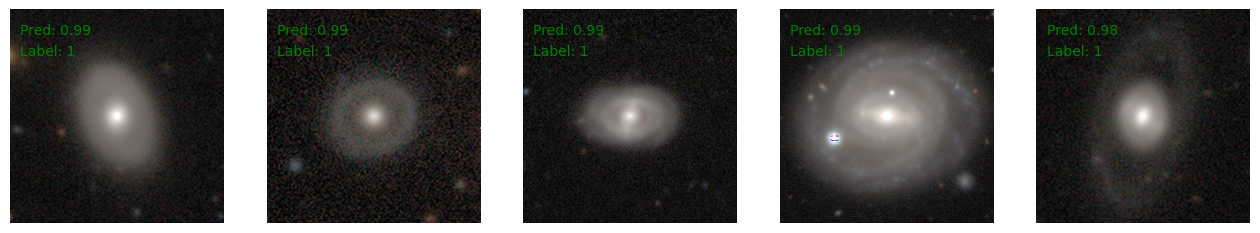

In [42]:
top_5_predictions = predictions.sort_values('ring_pred', ascending=False)
show_rings(top_5_predictions)

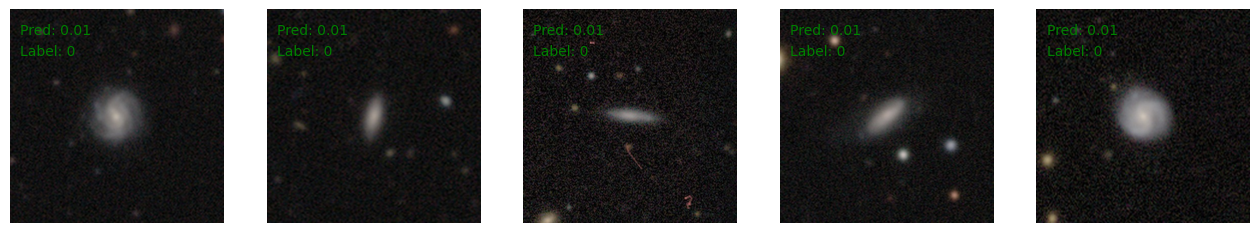

In [43]:
bottom_5_predictions = predictions.sort_values('ring_pred', ascending=True)
show_rings(bottom_5_predictions)

95     390415_3553
15     329088_5754
30     397084_3398
158     458992_900
128    426428_3219
Name: id_str, dtype: object


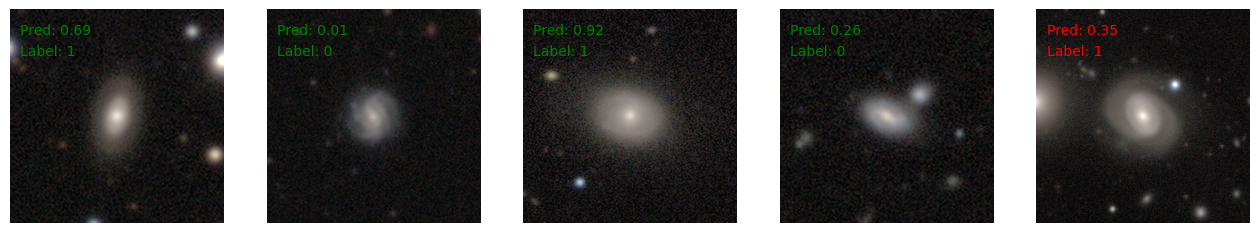

In [44]:
random_predictions = predictions.sample(5, random_state=42)
print(random_predictions['id_str'])
show_rings(random_predictions)